# An Introduction to Bayesian Optimization I

_Prepared by Ritz Aguilar for Thrill Summer School, 7-11 October 2024, France_

#### Objectives
- Introduce the fundamental concepts and purpose of Bayesian Optimization (BO).
- Learn about surrogate models for BO, specifically Gaussian Processes.
- Learn some of the acquisition/utility functions used in BO.

#### Definition
**Bayesian Optimization** is a global optimization method used for optimizing black-box functions that are expensive to evaluate, common in control and machine learning applications.


- **Problem**: We have an objective function $f(x)$, but we don't know its form and each evaluation is costly and/or noisy as in real-world problems. Our goal is to find the minimum of this noisy function: 
\begin{align}x^* = arg \min_x f(x).\end{align}

- **Solution**: Use a probabilistic surrogate model (e.g., Gaussian Process) to approximate $f(x)$ and an acquisition function to decide where to evaluate next.


#### Key Components
1. **Objective Function**: The ground truth function we want to learn/optimize. This is an unknown function, i.e. a black-box.
2. **Surrogate Model**: Estimates the objective function by using a surrogate model, i.e. a probabilistic model. _**Gaussian Processes (GP)**_ are often used as they provide both mean prediction and uncertainty for each point.
3. **Acquisition/Utility Functions**: Serves as a guide for deciding which point in the search space to evaluate next based on the current model of the objective function.

##### Set up the environment; import all libraries

In [2]:
## Uncomment to install the following library in your environment
# !pip install scikit-learn

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

## Gaussian Processes (GP) Regression

#### Exercise 1: GP Fitting

We will fit a GP to an objective function $f(x)$ and visualize the predictions. 

#### Define the objective function we want to optimize

In [48]:
np.random.seed(42)

noise_level = 0.25
def f(x, noise_level=noise_level):
    return np.exp(-x) * np.sin(4 * x) + np.random.randn(*x.shape) * noise_level

In [49]:
# Define input range for plotting the objective function f
bounds = np.array([[-2.0, 2.0]])
X = np.linspace(bounds[:, 0], bounds[:, 1], 100).reshape(-1, 1)
Y = f(X, noise_level=0)

#### Create training data

Let's say our training data has 10 initial samples (observations).

In [50]:
X_train = np.random.uniform(bounds[:, 0], bounds[:, 1], 10).reshape(-1, 1)
Y_train = f(X_train)

We then plot the ground truth (objective) function without noise, the noisy samples, and the initial observation points.

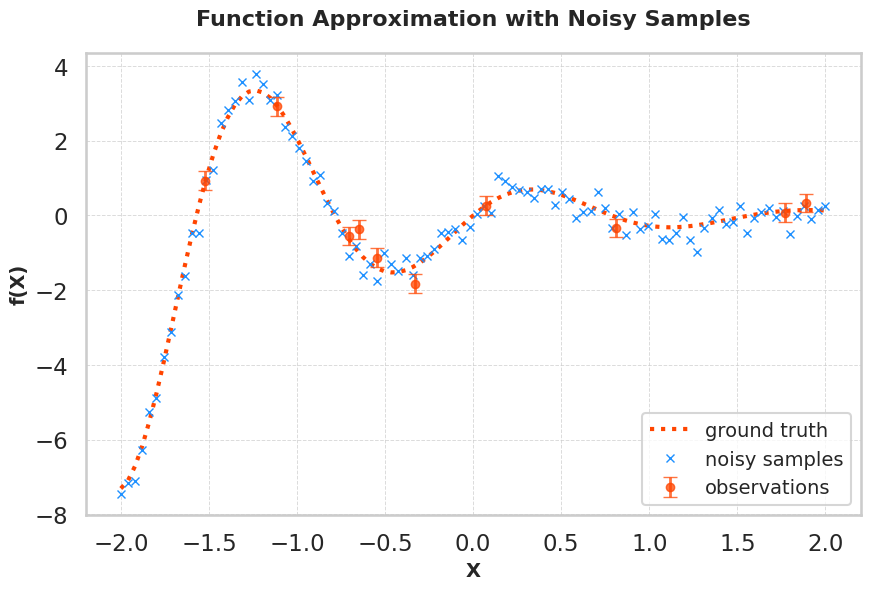

In [112]:
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(10, 6))
plt.plot(X, Y, c='#FF4500', ls=':', lw=3, label=r'ground truth') 
plt.plot(X, f(X, noise_level), c='#1E90FF', marker='x', ms=6, ls='', label='noisy samples')
plt.errorbar(X_train.flatten(), Y_train.flatten(), yerr=noise_level, 
             c='#FF4500', fmt='.', ms=12, capsize=5, elinewidth=2,  alpha=0.75, label='observations', )  

plt.title("Function Approximation with Noisy Samples", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("X", fontsize=14, fontweight='bold')
plt.ylabel("f(X)", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

Now, we sample points from the objective function which is unknown to us. In the lab, we can only measure a few points (often noisy) and infer the unknown function from points (priors).

Define a Gaussian Process model with combined effect of multiple kernels and then fit the model to the sampled data.

In [53]:
# Define the kernel: constant kernel * RBF kernel
kernel = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Use GP as a surrogate model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=noise_level**2)

# Fit the GP model to your training data
gp.fit(X_train, Y_train)

GaussianProcessRegressor(alpha=0.0625, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

#### Predict over the specified input range for plotting the objective function

In [56]:
# # Predict at new data points
# X_new = np.linspace(-2, 2, 100).reshape(-1, 1)
Y_pred, sigma = gp.predict(X, return_std=True)

Above: _y_pred_ is the mean prediction and _sigma_ would be the standard deviation.

#### Plot the result for a single iteration

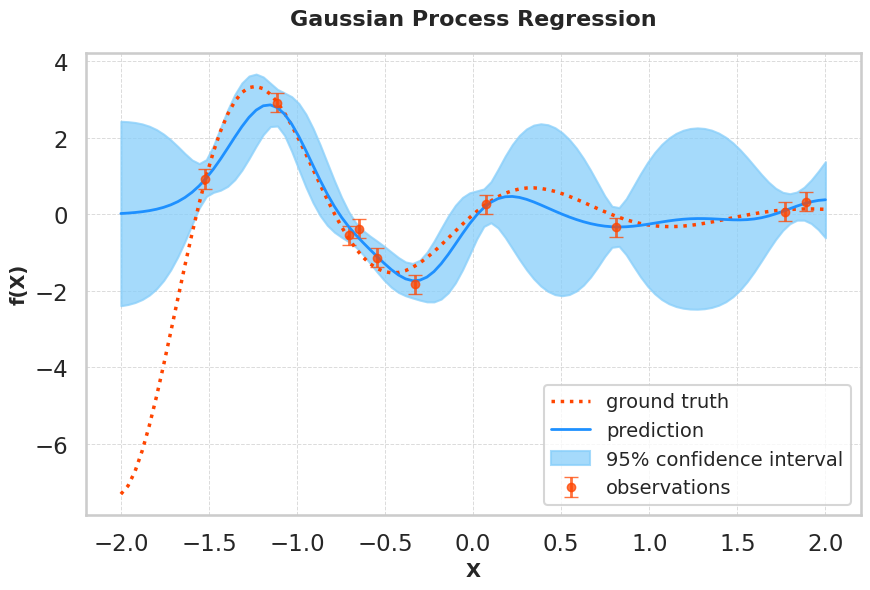

In [110]:
# Plotting the GP predictions
plt.figure(figsize=(10, 6))

plt.plot(X, Y, c='#FF4500', ls=':', lw=2.5, label=r'ground truth')
plt.errorbar(X_train.flatten(), Y_train.flatten(), yerr=noise_level, 
             c='#FF4500', fmt='.', ms=12, capsize=5, elinewidth=2,  alpha=0.75, label='observations', )  
plt.plot(X, Y_pred, c='#1E90FF', lw=2, label='prediction')  
plt.fill_between(X.ravel(), 
                 Y_pred - 1.96 * sigma, 
                 Y_pred + 1.96 * sigma, 
                 color='#87CEFA', alpha=0.75, label='95% confidence interval')

plt.title("Gaussian Process Regression", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("X", fontsize=14, fontweight='bold')
plt.ylabel("f(X)", fontsize=14, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(loc='lower right', fontsize=14)

plt.show()

**Exercise 1.1** Adjust the number of observation data points to see how it affects the GP’s confidence.

##### Sol 1.1

**Exercise 1.2** Play around with different noise levels and see how it affects the measured value.

##### Sol 1.2

#### Exercise 2: Bayesian Optimization Loop

To optimize the objective function iteratively, we follow the steps outlined below for $t = 1, 2, \ldots, T$:

1. **Construct a Probabilistic Model**: Start with the observations $x_i, y_i = f(x_i)$ for $i = 1:t$ to build a probabilistic model of the objective function $f$. This involves integrating over all possible true functions using GP regression.

2. **Select the Next Sampling Point**: Choose the next point to sample, $x_{t+1}$, by finding the maximum of the _acquisition function_ $u$ based on the current observations:
   $x_{t+1} = \arg \max_x u(x)$.
   This step helps balance exploration and exploitation by leveraging uncertainty in the model.

3. **Sample the Objective Function**: Evaluate the objective function at the selected point, obtaining $y_{t+1} = f(x_{t+1})$. Add this new observation to the existing dataset.

4. **Update the Surrogate Model**: Update the surrogate function $g(\cdot)$ to incorporate the newly sampled point $(x_{t+1}, y_{t+1})$.

References: 
1. https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html
2. https://sassafras13.github.io/BayesianOptimization/

In [ ]:
# We first put everything together and neatly into functions.

def objective_function():
    kernel = C(params[0], (1e-3, 1e3)) * RBF(params[1], (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, y_train)
    predictions = gp.predict(X_test)
    return -mean_squared_error(y_test, predictions)

kernel = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit the GP model to the sampled data
gp.fit(X, Y)

## Testing out Different Kernels

## Extensions

There are other Python-based libraries offering more streamlined approaches to perform BO. These include:
- $\texttt{skopt}$ - built on top of $\texttt{numpy}$, $\texttt{scipy}$, and $\texttt{scikit-learn}$
- $\texttt{bayesian-optimization}$ - pure Python implementation of BO with GP
- $\texttt{gpax}$ - built on top of $\texttt{NumPyro}$ and $\texttt{JAX}$, allows for running on GPU; better to create a new environment for this one

In [ ]:
# !pip install bayesian-optimization

References
1. [F. Nogueira (2014), Bayesian Optimization: Open source constrained global optimization tool for Python](https://bayesian-optimization.github.io/BayesianOptimization)
2. [E. Lee (2023), Bayesian Optimization with Python](https://drlee.io/bayesian-optimization-with-python-b544255757d3)
3. [S. V. Kalinin (2023), Bayesian Optimization for Automated Experiments](https://github.com/SergeiVKalinin/AutomatedExperiment_Summer2023)
4. https://distill.pub/2020/bayesian-optimization/
5. https://nbviewer.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-optimization/bayesian_optimization.ipynb